In [12]:
#We will get the HURDAT data directly from the website using requests
import requests

#For various numerical tasks
import numpy as np

#Pandas and geopandas will hold our data in dataframes and geodataframes
import pandas as pd
import geopandas as gpd

#Shapely will handle our geometry
from shapely.geometry import LineString
from shapely.wkt import loads

#For plotting
import matplotlib.pyplot as plt
from PIL import Image

Text(0.5, 1.0, 'Mainland US Area')

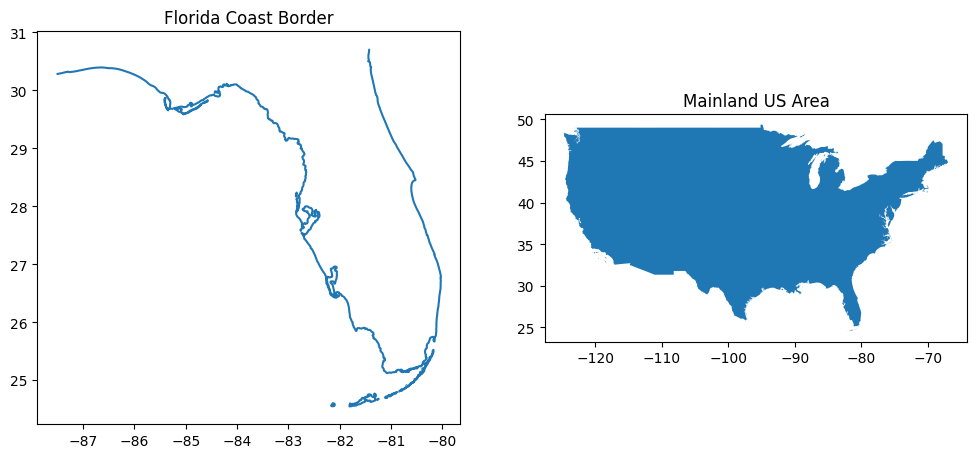

In [3]:
#We have this file of US border data from the link:  https://eric.clst.org/tech/usgeojson/
#gdf = GeoDataFrame
gdf = gpd.read_file('gz_2010_us_outline_500k.json')

#We will grab the x and y coordinates of each line of the border (beginning and end_
x1 = gdf.geometry.apply(lambda geom: geom.coords[0][0])
y1 = gdf.geometry.apply(lambda geom: geom.coords[0][1])
x2 = gdf.geometry.apply(lambda geom: geom.coords[1][0])
y2 = gdf.geometry.apply(lambda geom: geom.coords[1][1])

#We will select out this range to get rid of Alaska, Hawaii, and other islands
in_range = ((-130 < x1) & (x1 < -50)) & ((24 < y1) & (y1 < 50))
mainland = gdf[in_range]
#build_area() turns the border into an area, since we want to check whether points are inside
us_area = mainland.build_area()

#We further restrict the range to get the florida coast
in_range = ((-87.4 < x1) & (x1 < -79)) & ((24 < y1) & (y1 < 30.71))
florida_coast = gdf[in_range]

#See data plotted below
fig,ax=plt.subplots(1,2,figsize=(12,10))
florida_coast.plot(ax=ax[0])
ax[0].set_title("Florida Coast Border")
us_area.plot(ax=ax[1])
ax[1].set_title("Mainland US Area")

In [4]:
dfl = pd.read_csv('dataframes/dfl.csv')
dfl['geometry']=loads(dfl['geometry'])
dfl = gpd.GeoDataFrame(dfl,crs=us_area.crs)
dfp = pd.read_csv('dataframes/dfp.csv')
dfp['geometry'] = loads(dfp['geometry'])
dfp = gpd.GeoDataFrame(dfp,crs=us_area.crs)
dfh = pd.read_csv('dataframes/dfh.csv')
combined_storm_data = pd.read_csv('combined_storm_data.csv')

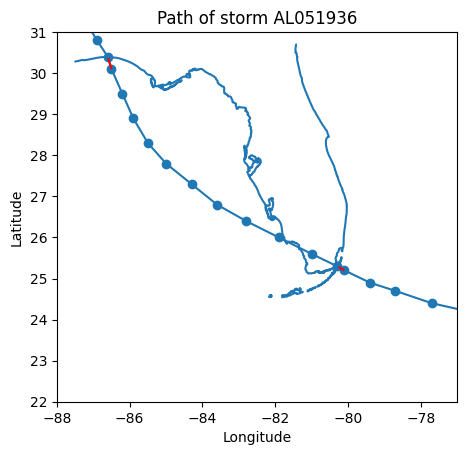

In [16]:
def plot_storm(storm_id,ax):
    line_data = dfl[dfl['storm_id'] == storm_id]
    point_data = dfp[dfp['storm_id'] == storm_id]
    line_data.plot(ax=ax)

    landfall_lines = line_data[line_data['landfall']]
    landfall_lines.plot(ax=ax,color='red')
    
    point_data.plot(ax=ax)
    florida_coast.plot(ax=ax)
    ax.set_title(f'Path of storm {storm_id}')
    ax.set_xlim([-88,-77])
    ax.set_ylim([22,31])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

def compress_png(input_path, output_path, colors=256):
    try:
        img = Image.open(input_path)
        # Convert to 'P' mode (palette-based) and quantize colors
        img = img.quantize(colors=colors)
        img.save(output_path, optimize=True)
    except FileNotFoundError:
        print(f"Error: Input file not found at {input_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

fig,ax=plt.subplots()
plot_storm('AL051936',ax)

In [17]:
storm_ids = combined_storm_data['storm_id']

for storm_id in storm_ids:
    fig,ax=plt.subplots()
    plot_storm(storm_id,ax)
    plt.savefig(f'figs/storm{storm_id}.png')
    plt.close(fig)
    compress_png(f'figs/storm{storm_id}.png',f'figs/storm{storm_id}.png')